# Spotify song popularity predictor
This is a supervised machine learning notebook, we'll have a regression and a classification model.

____

We have two datasets filled with informations about songs uploaded on Spotify. In each dataset, we have a column "popularity" which will be our machine learning models' target.

Each dataset treats the popularity as a different variable, the first one treats it as a boolean, the other as a number on a scale from 0 to 100. 

This way we can have both a regression and a classification model to treat each dataset.

# Summary
- Regression:
    - Data analysis & cleanup
    - Label Encoder
    - Standard Scaler
    - Finding the best Regressor
    - Grid Search on Random Forest models


- Classification:
    - Data analysis & cleanup
    - Label Encoder
    - Standard Scaler
    - Finding the best Classifier
    - Logistic Regression model

# Library

In [1]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Library
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV

# Regression
from sklearn import tree
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

# Classification
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from warnings import filterwarnings
filterwarnings('ignore')

# Regression

## Data

In [2]:
data_regression = pd.read_csv("./data/data_regression.csv", encoding='utf-8')
data_regression = data_regression.drop("Unnamed: 0", axis=1)
data_regression.head()

,artist_name,track_name,track_id,popularity,genre,year,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,beat_duration,tatum_duration
0,PEDRO SAMPAIO,DANÇARINA,5AT1GKRcXAzgjbF86kc4O5,1,Ostentacao,2022,0.778,0.571,9,-4.776,...,0.0788,0.0423,0.0,0.0964,0.554,134.999,110222,4,1.773955,0.221700
1,Mc Pedrinho,DANÇARINA,0ISAN8BdKHRdPrW2mdlKNz,0,Ostentacao,2022,0.778,0.571,9,-4.776,...,0.0788,0.0423,0.0,0.0964,0.554,134.999,110222,4,1.773955,0.221700
2,MC Kevinho,Olha A Explosão,6Q4foUefrAyCt8VxJFML56,67,Ostentacao,2016,0.778,0.635,6,-2.892,...,0.1120,0.1070,0.0,0.0608,0.379,90.008,162053,4,2.693884,0.335178
3,Mc Kadu,Vê Se Me Acha,52iyuDZKt7PoR9TdutXr7c,18,Ostentacao,2022,0.917,0.668,1,-2.889,...,0.1380,0.7100,0.0,0.0689,0.775,113.347,276706,5,2.092276,0.264835
4,DJ Matt D,Pandora,0yL7K9MzC20uBesZTPY81r,81,Ostentacao,2021,0.688,0.458,1,-9.138,...,0.5880,0.1400,0.0,0.4070,0.559,124.553,177000,4,1.925308,0.242900


## Missing values & duplicates

In [3]:
data_regression.drop_duplicates()
data_regression = data_regression.dropna()

In [4]:
print("Percentage of missing values on each column :\n")
print(((data_regression.isnull().sum()/data_regression.shape[0])*100).sort_values(ascending=False))

Percentage of missing values on each column :

artist_name         0.0
speechiness         0.0
beat_duration       0.0
time_signature      0.0
duration_ms         0.0
tempo               0.0
valence             0.0
liveness            0.0
instrumentalness    0.0
acousticness        0.0
mode                0.0
track_name          0.0
loudness            0.0
key                 0.0
energy              0.0
danceability        0.0
year                0.0
genre               0.0
popularity          0.0
track_id            0.0
tatum_duration      0.0
dtype: float64


We are not missing any values from the database.

## Features
- Description
- Correlations

In [5]:
data_regression.columns.to_list()

['artist_name',
 'track_name',
 'track_id',
 'popularity',
 'genre',
 'year',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'beat_duration',
 'tatum_duration']

Our target is the column "popularity". Considering we only have around 20 columns, there is no need to remove many features for our model.

We'll remove the track id, the track name and the artist name.

In [6]:
features = data_regression.columns.to_list()
features.remove("artist_name")
features.remove("track_name")
features.remove("track_id")
features.remove("popularity")
features

['genre',
 'year',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'beat_duration',
 'tatum_duration']

### Correlations

The genre of a song seems to somewhat be correlated to its popularity. 

We can also see two things on the correlation box :
- the energy is correlated to the loudness,
- the valence is correlated to the energy, the danceability and the loudness.

#### Correlations between features

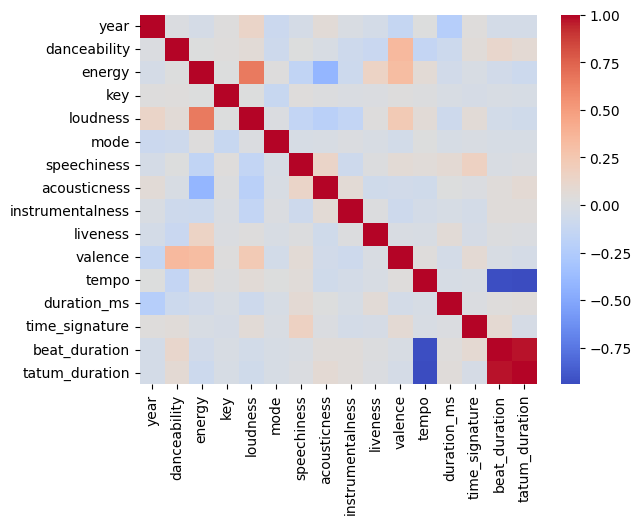

In [7]:
cor_heatmap = sns.heatmap(data_regression[['year',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'beat_duration',
 'tatum_duration']].corr(), cmap="coolwarm")

#### Correlations between features and target

In [8]:
data_encoded = data_regression.copy()
le = LabelEncoder()
for col in data_encoded:
    le.fit(data_encoded[col])
    data_encoded[col] = le.transform(data_encoded[col])
data_encoded.corr()['popularity'].sort_values()

speechiness        -0.206677
valence            -0.156984
danceability       -0.150215
year               -0.100702
time_signature     -0.091591
acousticness       -0.064028
artist_name        -0.046046
tatum_duration     -0.031316
beat_duration      -0.030570
key                -0.022171
track_id           -0.021034
instrumentalness   -0.012308
track_name          0.015286
loudness            0.015702
energy              0.019256
tempo               0.031893
mode                0.039320
liveness            0.056751
duration_ms         0.077118
genre               0.272047
popularity          1.000000
Name: popularity, dtype: float64

## Generating X and y for our models

In [9]:
X = data_regression[['genre',
 'year',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'beat_duration',
 'tatum_duration']].copy()

y = data_regression[["popularity"]]

### Label Encoding some of our features

In [10]:
data_to_label= X[["genre", "time_signature", "key", "mode"]].copy()

le = LabelEncoder()
le_count = 0

for col in data_to_label:
    le.fit(X[col])
    X[col] = le.transform(X[col])
    le_count += 1
    print(col)
X.reset_index()
print('%d columns were label encoded.' % le_count)

genre
time_signature
key
mode
4 columns were label encoded.


### Standard Scaler on features that could badly influence the model otherwise.
Because a value A is bigger than a value B, the model could think A is more important than B. This is why we'll use standard scaler on columns such as :

```year```, ```tempo```, ```beat_duration```, and ```duration_ms```. 

Just to be safe, we'll use the standard scaler on all of the remaining features as well.

In [11]:
sc = StandardScaler()
scale_count = 0

data_to_scale = X[['year',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'beat_duration',
 'tatum_duration']].copy()

for col in data_to_scale:
    X[col] = sc.fit_transform(X[[col]])
    scale_count += 1
    print(col)
X.reset_index()
print('%d columns were scaled.' % scale_count)

year
danceability
energy
loudness
speechiness
acousticness
instrumentalness
liveness
valence
tempo
duration_ms
beat_duration
tatum_duration
13 columns were scaled.


In [12]:
X

,genre,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,beat_duration,tatum_duration
0,2,0.744634,0.530758,-0.688414,9,0.313461,0,-0.526701,-0.845430,-0.136708,-0.539864,-0.165297,0.493421,-1.730384,2,-0.638272,-0.686412
1,2,0.744634,0.530758,-0.688414,9,0.313461,0,-0.526701,-0.845430,-0.136708,-0.539864,-0.165297,0.493421,-1.730384,2,-0.638272,-0.686412
2,2,-0.326879,0.530758,-0.277391,6,1.065810,1,-0.253534,-0.539803,-0.136708,-0.805711,-1.000534,-1.025512,-0.862325,2,1.254001,1.157822
3,2,0.744634,1.624571,-0.065458,1,1.067008,0,-0.039608,2.308628,-0.136708,-0.745223,0.889488,-0.237568,1.057869,3,0.016507,0.014616
4,2,0.566049,-0.177466,-1.414125,1,-1.428441,0,3.662958,-0.383918,-0.136708,1.779581,-0.141433,0.140755,-0.611995,2,-0.326942,-0.341864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,0,0.387463,0.790440,-0.470058,2,-0.239219,0,-0.655879,0.523044,0.744930,-0.903537,0.865624,-0.585913,0.241661,2,0.468237,0.444175
2307,0,-1.041221,-0.161728,1.283209,1,0.124975,1,-0.603220,-0.393366,-0.136708,-0.430836,1.027898,0.155137,-0.167841,2,-0.363998,-0.387487
2308,0,-0.326879,-1.349971,-0.797591,10,-0.256790,0,1.573066,1.850422,-0.136670,-0.371095,0.760623,2.636490,0.029365,2,-1.520265,-1.528195
2309,0,0.387463,-1.129635,0.557498,5,0.953996,0,0.980655,-0.213863,-0.136708,-0.762399,-0.112797,-1.510047,0.419273,2,2.183104,2.168185


## Train test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Finding the most suited model

-- How will we judge our regressors ? --

- The Mean Absolute Error takes the differences in all of the predicted and actual results, adds them up and then divides them by the number of observations. It doesn’t matter if the prediction is higher or lower than the actual result, the algorithm just looks at the absolute value. A lower value indicates better accuracy

- MSE and RMSE are really useful when you want to see if the outliers are messing with your predictions. 

- The r2 score measures the amount of variance in the predictions. Simply put, it is the difference between the samples in the dataset and the predictions made by the model. If the value of the r2 score is 1, it means that the model is perfect and if its value is 0, it means that the model will perform badly on an unseen dataset. If the r2 score drops after using cross validation, then the model suffers from overfitting.

In [14]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [15]:
# Models Performance
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tRMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print("\tR2 score using cross validation:", cross_val_score(model, X, y, cv=10, scoring="r2").mean())
    print()

KNeighborsRegressor()
	Training time: 0.005s
	Prediction time: 0.236s
	Explained variance: -0.028750782660146523
	Mean absolute error: 12.47550432276657
	RMSE: 19.745244931535797
	R2 score: -0.0378229939659398
	R2 score using cross validation: -1.8497523688327662

GradientBoostingRegressor()
	Training time: 1.354s
	Prediction time: 0.002s
	Explained variance: 0.5568889416434715
	Mean absolute error: 8.115356185530725
	RMSE: 12.902502457163209
	R2 score: 0.5568547088331357
	R2 score using cross validation: -0.9341370678495888

ExtraTreesRegressor()
	Training time: 1.470s
	Prediction time: 0.016s
	Explained variance: 0.5227409413568299
	Mean absolute error: 7.993731988472623
	RMSE: 13.3971797163278
	R2 score: 0.5222232581647243
	R2 score using cross validation: -0.7431967954358993

RandomForestRegressor()
	Training time: 4.385s
	Prediction time: 0.014s
	Explained variance: 0.5702117912116209
	Mean absolute error: 7.719480547550432
	RMSE: 12.714094535213437
	R2 score: 0.5697022149579469
	

## Random Forest Regressors

The best mean absolute error is 7.8, we got this result from a Random Forest Regressor. Its r2 score is one of the best scores of the list.

Let's try a Random Forest Regressor with our data and some parameters.

In [16]:
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}
best_random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
best_random_forest.fit(X_train, y_train)
best_random_forest.score(X_train, y_train)

0.68724606175592

In [17]:
best_random_forest.best_params_

{'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'random_state': 18}

In [18]:
best_rf_model = RandomForestRegressor(n_estimators = 500, criterion="absolute_error", max_depth = 7, random_state = 18, max_features= 'sqrt').fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

print(best_rf_model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
print("\tRMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("\tR2 score:", r2_score(y_test, y_pred))
print("\tR2 score using cross validation:", cross_val_score(best_rf_model, X, y, cv=10, scoring="r2").mean())

RandomForestRegressor(criterion='absolute_error', max_depth=7,
                      max_features='sqrt', n_estimators=500, random_state=18)
	Training time: 0.003s
	Prediction time: 0.001s
	Explained variance: 0.4581190070263492
	Mean absolute error: 8.831678674351586
	RMSE: 14.31812920343182
	R2 score: 0.45427884186793055
	R2 score using cross validation: -0.9509635590810431


# Conclusion of Regression

In conclusion, our regression models did very poorly when confronted to cross validation. 
This shows our models suffered from overfitting. A way to explain this would be the size of our dataset : only 2311 rows.

# Classification

## Data

In [19]:
data_classification = pd.read_csv("./data/data_classification.csv", encoding= "utf-8")
data_classification = data_classification.drop("uri", axis=1)
data_classification.head()

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,popularity,decade
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,1,60s
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,60s
2,Melody Twist,Lord Melody,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,0,60s
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,0,60s
4,Uravu Solla,P. Susheela,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,0,60s


In [20]:
data_classification = data_classification.drop("track", axis=1)
data_classification = data_classification.drop("artist", axis=1)
data_classification.decade = data_classification.decade.str.strip('s')

### Missing values & duplicates

No missing values were found on this dataset.

In [21]:
data_classification.drop_duplicates()
data_classification = data_classification.dropna()
print("Percentage of missing values on each column :\n")
print(((data_classification.isnull().sum()/data_classification.shape[0])*100).sort_values(ascending=False))

Percentage of missing values on each column :

danceability        0.0
valence             0.0
popularity          0.0
sections            0.0
chorus_hit          0.0
time_signature      0.0
duration_ms         0.0
tempo               0.0
liveness            0.0
energy              0.0
instrumentalness    0.0
acousticness        0.0
speechiness         0.0
mode                0.0
loudness            0.0
key                 0.0
decade              0.0
dtype: float64


### Correlations between features

There seems to be correlations between :
- popularity and energy, loudness, valence and danceability.
- duration and number of sections
- loudness and energy
- valence and danceability

In [22]:
data_encoded = data_classification.copy()
le = LabelEncoder()
for col in data_encoded:
    le.fit(data_encoded[col])
    data_encoded[col] = le.transform(data_encoded[col])
print(data_encoded.corr()['popularity'].sort_values())
del data_encoded

instrumentalness   -0.433379
liveness           -0.084188
speechiness        -0.081224
sections           -0.060458
chorus_hit         -0.032481
acousticness       -0.002334
decade              0.000129
duration_ms         0.007786
key                 0.009923
tempo               0.038010
mode                0.079633
time_signature      0.105529
energy              0.197870
loudness            0.271012
valence             0.272065
danceability        0.346023
popularity          1.000000
Name: popularity, dtype: float64


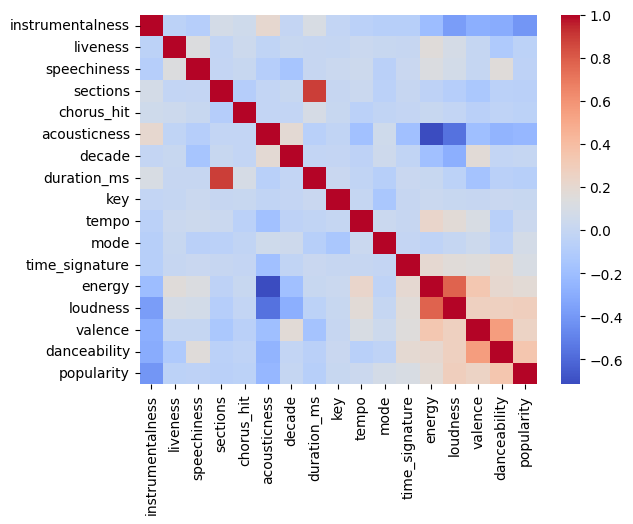

In [23]:
cor_heatmap = sns.heatmap(data_classification[[
 'instrumentalness',
 'liveness',
 'speechiness',
 'sections',
 'chorus_hit',
 'acousticness',
 'decade',
 'duration_ms',
 'key',
 'tempo',
 'mode',
 'time_signature',
 'energy',
 'loudness',
 'valence',
 'danceability',
 'popularity']].corr(), cmap="coolwarm")

## Generating X and y for our models

In [24]:
X = data_classification[['instrumentalness',
                         'liveness',
                         'speechiness',
                         'sections',
                         'chorus_hit',
                         'acousticness',
                         'decade',
                         'duration_ms',
                         'key',
                         'tempo',
                         'mode',
                         'time_signature',
                         'energy',
                         'loudness',
                         'valence',
                         'danceability']]
y = data_classification[['popularity']]

### Label Encoding

In [25]:
data_to_label = X[["key", "mode", "time_signature", "sections", "decade"]].copy()

le = LabelEncoder()
le_count = 0

for col in data_to_label:
    le.fit(X[col])
    X[col] = le.transform(X[col])
    le_count += 1
    print(col)
X.reset_index()
print('%d columns were label encoded in X.' % le_count)


le.fit(y["popularity"])
y["popularity"] = le.transform(y["popularity"])
print("Column popularity was label encoded in y.")

key
mode
time_signature
sections
decade
5 columns were label encoded in X.
Column popularity was label encoded in y.


### Standard Scaler 

In [26]:
sc = StandardScaler()
scale_count = 0


data_to_scale = X[['instrumentalness',
                   'liveness',
                   'speechiness',
                   'chorus_hit',
                   'acousticness',
                   'duration_ms',
                   'tempo',
                   'energy',
                   'loudness',
                   'valence',
                   'danceability'
                  ]].copy()

for col in data_to_scale:
    X[col] = sc.fit_transform(X[[col]])
    scale_count += 1
    print(col)
X.reset_index()
print('%d columns were scaled.' % scale_count)

instrumentalness
liveness
speechiness
chorus_hit
acousticness
duration_ms
tempo
energy
loudness
valence
danceability
11 columns were scaled.


## Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models

In [28]:
def print_conf_matrix(y_test_, y_pred_):
    conf_matrix = metrics.confusion_matrix(y_test_, y_pred_)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

    print('The confusion matrix shows us the number of :\n')
    print('* True positives :', conf_matrix[0][0] ,'\n')
    print('* False positives :', conf_matrix[0][1],'\n')
    print('* False negatives :', conf_matrix[1][0] ,'\n')
    print('* True negatives :', conf_matrix[1][1] ,'\n')

In [29]:
classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    DecisionTreeClassifier(criterion='gini', min_samples_split=2)
]

LogisticRegression() 

              precision    recall  f1-score   support

           0       0.77      0.64      0.70      6163
           1       0.69      0.80      0.74      6167

    accuracy                           0.72     12330
   macro avg       0.73      0.72      0.72     12330
weighted avg       0.73      0.72      0.72     12330



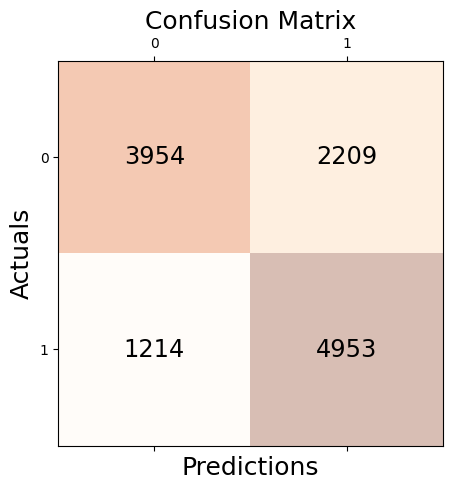

The confusion matrix shows us the number of :

* True positives : 3954 

* False positives : 2209 

* False negatives : 1214 

* True negatives : 4953 

______________________

RandomForestClassifier() 

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      6163
           1       0.77      0.85      0.81      6167

    accuracy                           0.80     12330
   macro avg       0.80      0.80      0.80     12330
weighted avg       0.80      0.80      0.80     12330



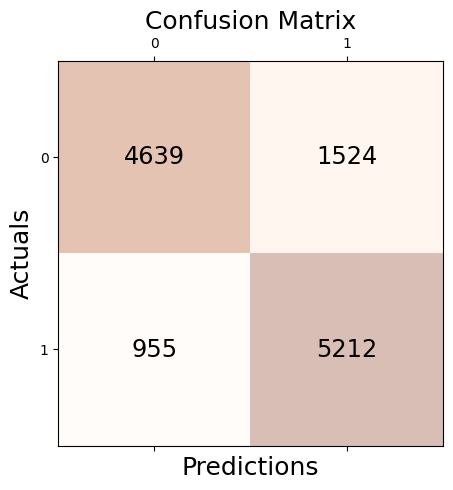

The confusion matrix shows us the number of :

* True positives : 4639 

* False positives : 1524 

* False negatives : 955 

* True negatives : 5212 

______________________

DecisionTreeClassifier() 

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      6163
           1       0.72      0.72      0.72      6167

    accuracy                           0.72     12330
   macro avg       0.72      0.72      0.72     12330
weighted avg       0.72      0.72      0.72     12330



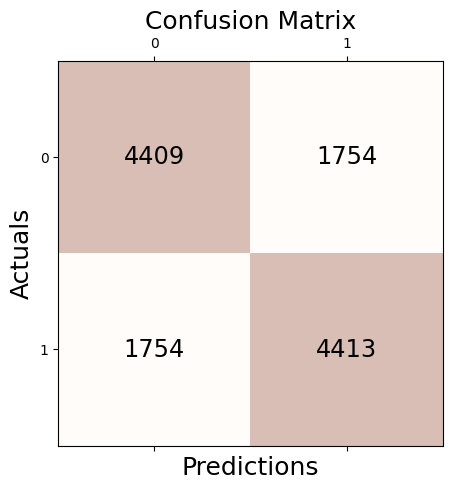

The confusion matrix shows us the number of :

* True positives : 4409 

* False positives : 1754 

* False negatives : 1754 

* True negatives : 4413 

______________________



In [30]:
for model in classifiers:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model, "\n")
    print(classification_report(y_test, y_pred))
    print_conf_matrix(y_test, y_pred)
    print("______________________\n")

# Conclusion of Classification

Our Random Forest Classifier was our best classification model.